In [1]:
# Dependencies
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)
#api_key


# Read crime data file   

In [2]:
file='NYPD_Data.csv'
df=pd.read_csv(file)
df.head()
# convert CMPLNT_FR_DT to date format. 222398 rows records in file
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'],errors = 'coerce') 
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)"
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)"
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)"
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)"
4,145366108,25.0,MANHATTAN,2019-02-11,12:07:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1002776.0,231994.0,40.803435,-73.933084,"(40.80343468, -73.93308448)"


In [3]:
# Filter for only "Felony" category
felonyDf = df[df["LAW_CAT_CD"] == 'FELONY'] 
felonyDf=felonyDf.reset_index(drop=True)
# Drop rows if CMPLNT_FR_DT does not have any value
felonyDf=felonyDf.dropna(subset = ['CMPLNT_FR_DT'])
# Limit our analysis to last 10 years - 2010 to 2019
felonyDf = felonyDf[(felonyDf['CMPLNT_FR_DT'] > '2010-01-01') & (felonyDf['CMPLNT_FR_DT'] <= '2019-09-06')]
# create new columns to store year and month to enable aggregration
felonyDf['CMPLNT_YR']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).year
felonyDf['CMPLNT_Month']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).month
#felonyDf.to_csv('felonyfull.csv')

felonyDf.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)",2019,3
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)",2019,1
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3


In [4]:
# Summary of felonies for the last 10 years
felonySummary=felonyDf.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felonySummary=felonySummary.rename(columns={'OFNS_DESC':"Total Count"})
# Sort by total offsense count to see the top 5 categories
felonySummary=felonySummary.sort_values('Total Count',ascending=False)
felonySummary.reset_index()

,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168
5,2019,BURGLARY,4712
6,2019,FORGERY,2594
7,2019,DANGEROUS WEAPONS,2333
8,2019,DANGEROUS DRUGS,2283
9,2019,GRAND LARCENY OF MOTOR VEHICLE,2084


In [5]:
# Limit our analysis to the top 5 offense categories , we end up with 47755 rows for our analysis
felony5 = felonyDf[(felonyDf['OFNS_DESC'] == 'GRAND LARCENY') | (felonyDf['OFNS_DESC'] == 'FELONY ASSAULT') | (felonyDf['OFNS_DESC'] == 'MISCELLANEOUS PENAL LAW') | (felonyDf['OFNS_DESC'] == 'ROBBERY') | (felonyDf['OFNS_DESC'] == 'CRIMINAL MISCHIEF & RELATED OF')]
felony5.head()
#felony5.to_csv('felony5.csv')

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3
7,816741975,18.0,MANHATTAN,2019-03-30,14:58:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3
9,530663781,44.0,BRONX,2019-03-02,7:19:00,NaN,NaN,COMPLETED,NaN,NaN,...,18-24,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3


In [6]:

# Group by CMPLNT_YR','OFNS_DESC to see aggregation for the top 5 offenses
felony5Summary=felony5.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felony5Summary=felony5Summary.rename(columns={'OFNS_DESC':"Total Count"})

felony5Summary=felony5Summary.sort_values('Total Count',ascending=False)
felony5Summary=felony5Summary.reset_index()
felony5Summary.head(5)


,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168


In [7]:
# Minor Data Munging to Re-Format the Data Frames
felony5pivot=felony5Summary.pivot(index='CMPLNT_YR',columns='OFNS_DESC', values='Total Count')
# Preview the Data Frame
felony5pivot=felony5pivot.reset_index()
felony5pivot=felony5pivot.fillna(0)
felony5pivot
#DataFrame.fillna()

OFNS_DESC,CMPLNT_YR,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,GRAND LARCENY,MISCELLANEOUS PENAL LAW,ROBBERY
0,2010,0.0,2.0,3.0,0.0,0.0
1,2011,1.0,0.0,2.0,0.0,2.0
2,2012,0.0,0.0,6.0,0.0,0.0
3,2013,1.0,0.0,9.0,0.0,0.0
4,2014,1.0,1.0,9.0,1.0,0.0
5,2015,0.0,2.0,26.0,1.0,0.0
6,2016,0.0,5.0,27.0,3.0,2.0
7,2017,14.0,4.0,106.0,6.0,0.0
8,2018,328.0,106.0,1613.0,174.0,31.0
9,2019,5168.0,9680.0,18012.0,6620.0,5789.0


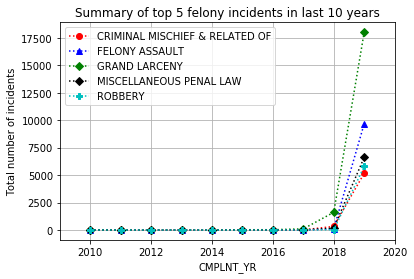

In [8]:
# Draw a line plot
ax = felony5pivot.plot( x="CMPLNT_YR",y="CRIMINAL MISCHIEF & RELATED OF", color="r", label="CRIMINAL MISCHIEF & RELATED OF",linestyle=':',marker='o')
felony5pivot.plot(x="CMPLNT_YR",y="FELONY ASSAULT", color="b", label="FELONY ASSAULT",linestyle=':',marker='^', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="GRAND LARCENY", color="g", label="GRAND LARCENY",linestyle=':',marker='D', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="MISCELLANEOUS PENAL LAW", color="k", label="MISCELLANEOUS PENAL LAW", linestyle=':',marker='D',ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="ROBBERY", color="c", label="ROBBERY", linestyle=':',marker='P',ax=ax)

plt.grid()
plt.xlim(2009,2020)
plt.title("Summary of top 5 felony incidents in last 10 years")
#plt.xlabel("Time (Days)")
plt.ylabel("Total number of incidents")
plt.legend()
plt.show()

In [9]:

felony5Boro=felony5.groupby(['BORO_NM','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felony5Boro=felony5Boro.rename(columns={'OFNS_DESC':"Total Count"})

felony5Boro=felony5Boro.sort_values('Total Count',ascending=False)
#felony5Boro=felony5Boro.reset_index()
#felony5Boro=felony5Boro.set_index('BORO_NM')
felony5Boro=felony5Boro.sort_values('OFNS_DESC')
felony5Boro=felony5Boro.reset_index()
felony5Boro
#felony5Boro.plot()

,BORO_NM,OFNS_DESC,Total Count
0,BRONX,CRIMINAL MISCHIEF & RELATED OF,1065
1,QUEENS,CRIMINAL MISCHIEF & RELATED OF,1446
2,STATEN ISLAND,CRIMINAL MISCHIEF & RELATED OF,246
3,MANHATTAN,CRIMINAL MISCHIEF & RELATED OF,1017
4,BROOKLYN,CRIMINAL MISCHIEF & RELATED OF,1739
5,STATEN ISLAND,FELONY ASSAULT,300
6,BROOKLYN,FELONY ASSAULT,2839
7,BRONX,FELONY ASSAULT,2825
8,QUEENS,FELONY ASSAULT,1927
9,MANHATTAN,FELONY ASSAULT,1909


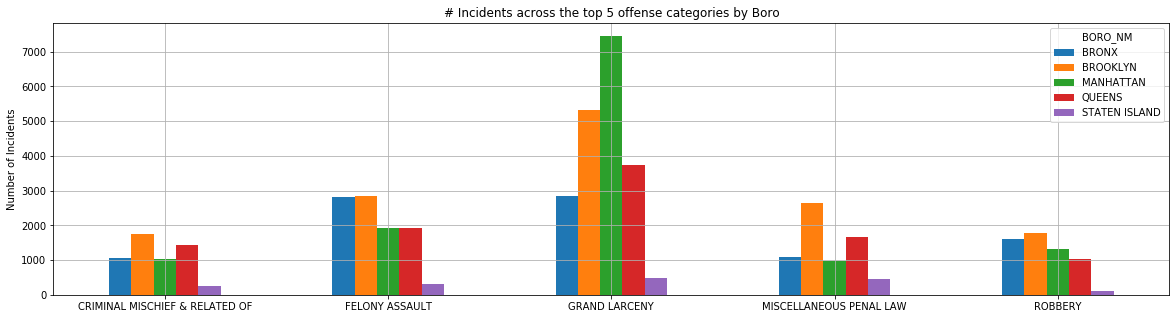

BORO_NM,OFNS_DESC,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,CRIMINAL MISCHIEF & RELATED OF,1065,1739,1017,1446,246
1,FELONY ASSAULT,2825,2839,1909,1927,300
2,GRAND LARCENY,2834,5314,7451,3738,475
3,MISCELLANEOUS PENAL LAW,1085,2646,967,1659,448
4,ROBBERY,1605,1784,1311,1027,97


<Figure size 432x288 with 0 Axes>

In [10]:
# Minor Data Munging to Re-Format the Data Frames
felony5Boropivot1=felony5Boro.pivot(index='OFNS_DESC',columns='BORO_NM', values='Total Count')
# Preview the Data Frame
felony5Boropivot1=felony5Boropivot1.reset_index()
felony5Boropivot1=felony5Boropivot1.fillna(0)
felony5Boropivot1
multi_plot = felony5Boropivot1.plot(kind="bar", figsize=(20,5))

# PandasPlot.set_xticklabels() can be used to set the tick labels as well
multi_plot.set_xticklabels(felony5Boropivot1['OFNS_DESC'], rotation=0)
plt.grid()
plt.title("# Incidents across the top 5 offense categories by Boro")
plt.ylabel("Number of Incidents")
plt.show()
plt.tight_layout()
plt.savefig("Incidents across the top 5 offense categories by Boro.png")
felony5Boropivot1
#DataFrame.fillna()

In [11]:
#Create Bins to categorzie crime times
bins=[0,4,8,12,16,20,24]
Groups=['MidNight','EarlyMor','Morning','Noon','Evening','Night']
felony5['CMPLNT_FR_TM'] = pd.to_datetime(felony5['CMPLNT_FR_TM']).dt.hour
felony5["CrimeTimes"] = pd.cut(felony5["CMPLNT_FR_TM"], bins, labels=Groups)
felony5.head()

C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month,CrimeTimes
0,857927015,10.0,MANHATTAN,2019-01-29,16,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1,Noon
2,320007604,41.0,BRONX,2019-02-06,2,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2,MidNight
4,889702556,32.0,MANHATTAN,2019-03-11,21,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3,Night
7,816741975,18.0,MANHATTAN,2019-03-30,14,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3,Noon
9,530663781,44.0,BRONX,2019-03-02,7,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3,EarlyMor


In [12]:

# Group by CMPLNT_YR','MPLNT_FR_TM to see aggregation for the top 5 offenses
felony5byTime=felony5.groupby(['BORO_NM','CrimeTimes']).agg({'OFNS_DESC':'count'})
felony5byTime=felony5byTime.rename(columns={'OFNS_DESC':"Total Count"})

felony5byTime=felony5byTime.sort_values('Total Count',ascending=False)
felony5byTime=felony5byTime.sort_values('CrimeTimes')
felony5byTime=felony5byTime.reset_index()
felony5byTime




,BORO_NM,CrimeTimes,Total Count
0,STATEN ISLAND,MidNight,140
1,MANHATTAN,MidNight,1415
2,BROOKLYN,MidNight,1545
3,QUEENS,MidNight,1145
4,BRONX,MidNight,1099
5,BRONX,EarlyMor,911
6,STATEN ISLAND,EarlyMor,158
7,QUEENS,EarlyMor,927
8,MANHATTAN,EarlyMor,971
9,BROOKLYN,EarlyMor,1344


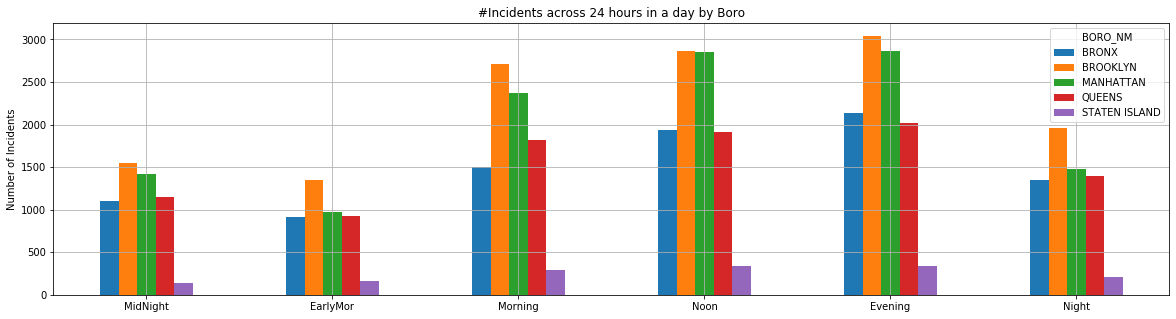

BORO_NM,CrimeTimes,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,MidNight,1099,1545,1415,1145,140
1,EarlyMor,911,1344,971,927,158
2,Morning,1502,2707,2371,1816,296
3,Noon,1936,2868,2855,1918,341
4,Evening,2130,3041,2868,2015,343
5,Night,1347,1965,1480,1399,210


<Figure size 432x288 with 0 Axes>

In [13]:
# Minor Data Munging to Re-Format the Data Frames
felony5timepivot1=felony5byTime.pivot(index='CrimeTimes',columns='BORO_NM', values='Total Count')
# Preview the Data Frame
felony5timepivot1=felony5timepivot1.reset_index()
#felony5timepivot1=felony5timepivot1.fillna(0)
felony5timepivot1
#DataFrame.fillna()
multi_plot = felony5timepivot1.plot(kind="bar", figsize=(20,5))
#multi_plot.set_xticklabels( rotation=45)
# PandasPlot.set_xticklabels() can be used to set the tick labels as well
multi_plot.set_xticklabels(felony5timepivot1["CrimeTimes"], rotation=0)
plt.title("#Incidents across 24 hours in a day by Boro")
plt.ylabel("Number of Incidents")
plt.grid()
plt.show()
plt.savefig("#Incidents across 24 hours in a day by Boro.png")
plt.tight_layout()
felony5timepivot1

## Heat Map for Crimes

In [14]:
# Store latitude and longitude in locations
locations = felony5[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
rating = felony5["CMPLNT_NUM"].astype(float)
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating)  

# Add layer
fig.add_layer(heat_layer)
#marker_locations=[(43, -72)]
#markers = gmaps.marker_layer(locations)
#fig.add_layer(markers)
#fig.add_layer(heat_layer,markers)
# Display figure
fig


Figure(layout=FigureLayout(height='420px'))

## Grad Data analysis by drop out count

In [17]:
#Importing the Data set for Gradution Rates and Latitude and Longitude lookup
GR_BySchool = "graduation_rates_public_school.csv"
HighSchool_Dir = "2017_DOE_High_School_Directory.csv"

In [18]:
#Reading the csv files.This is High School Data set in NYC
GR_BySchool_DF = pd.read_csv(GR_BySchool)
GR_BySchool_DF.head()

,DBN,School Name,Category,Cohort Year,Cohort,Cohort #,Total Grads #,Total Grads % of cohort,Total Regents #,Total Regents % of cohort,...,Regents without Advanced #,Regents without Advanced % of cohort,Regents without Advanced % of grads,Local #,Local % of cohort,Local % of grads,Still Enrolled #,Still Enrolled % of cohort,Dropout #,Dropout % of cohort
0,01M292,Orchard Collegiate Academy,All Students,2014,4 year August,29,28,96.6,25,86.2,...,25,86.2,89.3,3,10.3,10.7,0,0.0,1,3.4
1,01M292,Orchard Collegiate Academy,All Students,2013,4 year August,36,25,69.4,23,63.9,...,23,63.9,92.0,2,5.6,8.0,3,8.3,7,19.4
2,01M292,Orchard Collegiate Academy,All Students,2012,4 year August,44,24,54.5,20,45.5,...,19,43.2,79.2,4,9.1,16.7,10,22.7,10,22.7
3,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0,41,56.2,...,41,56.2,89.1,5,6.8,10.9,18,24.7,7,9.6
4,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.6,26,42.6,...,25,41.0,96.2,0,0.0,0.0,18,29.5,17,27.9


In [19]:
#Cleaning the dataset 
indexNames = GR_BySchool_DF[ (GR_BySchool_DF['Cohort Year'] == 2014) & (GR_BySchool_DF['Cohort'] == '4 year June') ].index
GR_BySchool_DF.drop(indexNames , inplace=True)
indexNames = GR_BySchool_DF[ (GR_BySchool_DF['Cohort Year'] == 2013) & (GR_BySchool_DF['Cohort'] == '5 year June') ].index
GR_BySchool_DF.drop(indexNames , inplace=True)
indexNames = GR_BySchool_DF[ (GR_BySchool_DF['Cohort Year'] == 2013) & (GR_BySchool_DF['Cohort'] == '4 year June') ].index
GR_BySchool_DF.drop(indexNames , inplace=True)
indexNames = GR_BySchool_DF[ (GR_BySchool_DF['Cohort Year'] == 2013) & (GR_BySchool_DF['Cohort'] == '4 year August') ].index
GR_BySchool_DF.drop(indexNames , inplace=True)
indexNames = GR_BySchool_DF[ (GR_BySchool_DF['Cohort Year'] < 2013) & (GR_BySchool_DF['Cohort'] != '6 year June') ].index
GR_BySchool_DF.drop(indexNames , inplace=True)

GR_BySchool_DF = GR_BySchool_DF.reset_index()
GR_BySchool_DF.head()

,index,DBN,School Name,Category,Cohort Year,Cohort,Cohort #,Total Grads #,Total Grads % of cohort,Total Regents #,...,Regents without Advanced #,Regents without Advanced % of cohort,Regents without Advanced % of grads,Local #,Local % of cohort,Local % of grads,Still Enrolled #,Still Enrolled % of cohort,Dropout #,Dropout % of cohort
0,0,01M292,Orchard Collegiate Academy,All Students,2014,4 year August,29,28,96.6,25,...,25,86.2,89.3,3,10.3,10.7,0,0.0,1,3.4
1,22,01M292,Orchard Collegiate Academy,All Students,2013,5 year August,36,27,75.0,23,...,23,63.9,85.2,4,11.1,14.8,0,0.0,8,22.2
2,41,01M292,Orchard Collegiate Academy,All Students,2012,6 year June,41,28,68.3,22,...,21,51.2,75.0,6,14.6,21.4,1,2.4,12,29.3
3,42,01M292,Orchard Collegiate Academy,All Students,2011,6 year June,68,49,72.1,42,...,42,61.8,85.7,7,10.3,14.3,5,7.4,14,20.6
4,43,01M292,Orchard Collegiate Academy,All Students,2010,6 year June,54,30,55.6,28,...,27,50.0,90.0,2,3.7,6.7,2,3.7,21,38.9


In [20]:
#Cleanup Data set to take only required columns
GR_BySchool_DF.columns
reduced_GR_BySchool_DF = GR_BySchool_DF.loc[:, ["DBN","School Name", "Category", "Cohort Year",
                                    "Cohort #", "Total Grads #", "Total Grads % of cohort","Dropout #","Dropout % of cohort"]]
reduced_GR_BySchool_DF.head()

,DBN,School Name,Category,Cohort Year,Cohort #,Total Grads #,Total Grads % of cohort,Dropout #,Dropout % of cohort
0,01M292,Orchard Collegiate Academy,All Students,2014,29,28,96.6,1,3.4
1,01M292,Orchard Collegiate Academy,All Students,2013,36,27,75.0,8,22.2
2,01M292,Orchard Collegiate Academy,All Students,2012,41,28,68.3,12,29.3
3,01M292,Orchard Collegiate Academy,All Students,2011,68,49,72.1,14,20.6
4,01M292,Orchard Collegiate Academy,All Students,2010,54,30,55.6,21,38.9


In [21]:
#Genarate Average % Grad and % Dropouts by Year 
TC_YearSummary=reduced_GR_BySchool_DF.groupby(['Cohort Year']).agg({'Cohort #':'sum'},)
GR_YearSummary=reduced_GR_BySchool_DF.groupby(['Cohort Year']).agg({'Total Grads #':'sum'},)
DR_YearSummary=reduced_GR_BySchool_DF.groupby(['Cohort Year']).agg({'Dropout #':'sum'},)
DR_YearSummary

,Dropout #
Cohort Year,
2001,16353
2002,15208
2003,14733
2004,13265
2005,13151
2006,13894
2007,14246
2008,12719
2009,12236


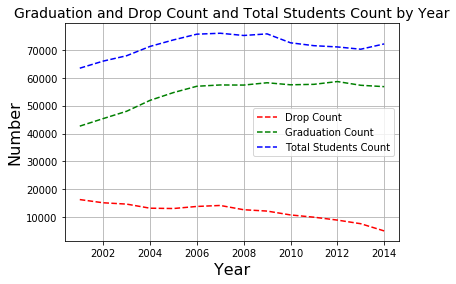

In [25]:
# Draw a line plot
plt.plot(DR_YearSummary,'r--', label="Drop Count")
plt.plot(GR_YearSummary,'g--',label="Graduation Count")
plt.plot(TC_YearSummary,'b--',label="Total Students Count")

plt.title("Graduation and Drop Count and Total Students Count by Year",fontsize=14)
plt.ylabel("Number",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.grid()
plt.legend()
plt.show()

# Save an image of the chart and print to screen.Count Plot
#plt.savefig("Images/Graduation and Drop Count and Total Students Count by Year.png")
plt.show()


In [26]:
#Reading the csv files.This is for High School Directory Data set in NYC
HighSchool_Dir_DF = pd.read_csv(HighSchool_Dir)
HighSchool_Dir_DF.head()

,dbn,school_name,boro,overview_paragraph,school_10th_seats,academicopportunities1,academicopportunities2,academicopportunities3,academicopportunities4,academicopportunities5,...,state_code,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Borough
0,02M260,"Clinton School Writers & Artists, M.S. 260",M,Students who are prepared for college must hav...,1.0,Free college courses at neighboring universities,"International Travel, Special Arts Programs, M...",NaN,NaN,NaN,...,NY,40.73653,-73.9927,5.0,2.0,52,"1,089,902","1,008,420,034",Hudson Yards-Chelsea-Flatiron-Union Square ...,MANHATTAN
1,21K728,Liberation Diploma Plus High School,K,The mission of Liberation Diploma Plus High Sc...,1.0,"Learning to Work, Student Council, Advisory Le...","CAMBA, Diploma Plus, Medgar Evers College, Con...",The Learning to Work (LTW) partner for Liberat...,NaN,NaN,...,NY,40.57698,-73.9854,13.0,47.0,326,"3,329,331","3,070,200,039",Seagate-Coney Island ...,BROOKLYN
2,08X282,Women's Academy of Excellence,X,The Womens Academy of Excellence is an all-gi...,NaN,"Genetic Research Seminar, Touro College Partne...","WAE Bucks Incentive Program, Monroe College Ju...","Pupilpath, Saturday school, Leadership class, ...","PEARLS Awards, Academy Awards, Rose Ceremony/P...",Health and Wellness Program,...,NY,40.81504,-73.8561,9.0,18.0,4,"2,020,580","2,034,780,018",Soundview-Castle Hill-Clason Point-Harding Par...,BRONX
3,17K548,Brooklyn School for Music & Theatre,K,Brooklyn School for Music & Theatre (BSMT) use...,1.0,"CTE program(s) in: Arts, A/V Technology & Comm...",iLearnNYC: Program for expanded online coursew...,We offer highly competitive positions in our D...,Students receive small group instruction focus...,NaN,...,NY,40.66981,-73.9607,9.0,35.0,213,"3,029,686","3,011,870,001",Crown Heights South ...,BROOKLYN
4,27Q314,Epic High School - South,Q,"Epic High School  South, an outgrowth of the ...",NaN,Culturally relevant practices; Blended instruc...,"Real-world problem-based learning, Student cho...",Mentoring; Rites of passage experiences; Colle...,NaN,NaN,...,NY,40.67502,-73.8167,10.0,28.0,840,"4,253,607","4,117,140,100",South Ozone Park ...,QUEENS


In [27]:
#Cleaning up#Cleanup Data set to take only required columns
HighSchool_Dir_DF.columns

reduced_HighSchool_Dir_DF = HighSchool_Dir_DF.loc[:, ["dbn","school_name", "Latitude", "Longitude","Borough",
                                                      "city","Postcode"]]
reduced_HighSchool_Dir_DF=reduced_HighSchool_Dir_DF.rename(columns={'dbn':"DBN"})
reduced_HighSchool_Dir_DF.head()


,DBN,school_name,Latitude,Longitude,Borough,city,Postcode
0,02M260,"Clinton School Writers & Artists, M.S. 260",40.73653,-73.9927,MANHATTAN,Manhattan,10003
1,21K728,Liberation Diploma Plus High School,40.57698,-73.9854,BROOKLYN,Brooklyn,11224
2,08X282,Women's Academy of Excellence,40.81504,-73.8561,BRONX,Bronx,10473
3,17K548,Brooklyn School for Music & Theatre,40.66981,-73.9607,BROOKLYN,Brooklyn,11225
4,27Q314,Epic High School - South,40.67502,-73.8167,QUEENS,South Ozone Park,11420


In [28]:
#Merging 2 Data sets to find Latitude and Longitude for each High School to get Dropout % 
School_df = pd.merge(reduced_GR_BySchool_DF, reduced_HighSchool_Dir_DF)
Avg_DR_School_df = School_df.groupby(['School Name','Latitude','Longitude']).agg({'Dropout #':'sum'},
                                                                                 'Latitude','Longitude')
Avg_DR_School_df = Avg_DR_School_df.reset_index(drop=False)
Avg_DR_School_df.head()


,School Name,Latitude,Longitude,Dropout #
0,47 The American Sign Language and English Seco...,40.73837,-73.9813,26
1,A. Philip Randolph Campus High School,40.81850,-73.9499,511
2,ACADEMY FOR SOCIAL ACTION,40.81575,-73.9555,73
3,ACORN Community High School,40.67859,-73.9616,305
4,ARTS & MEDIA PREPARATORY ACADEMY,40.65909,-73.9287,67


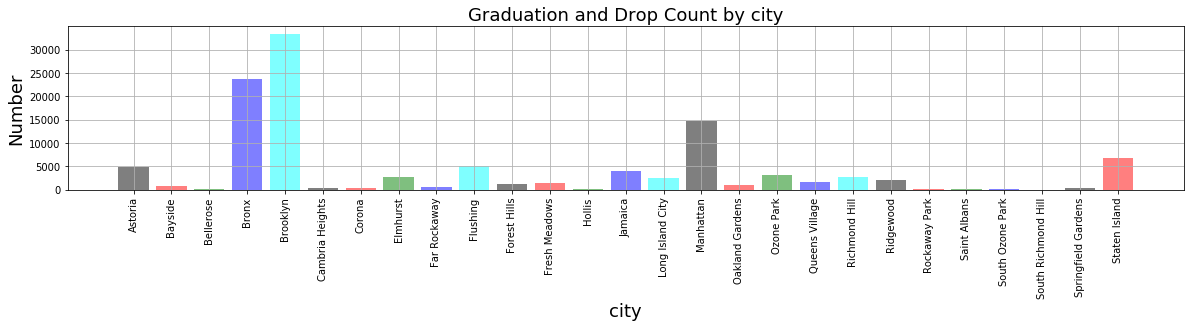

In [30]:
#Ploting Highest Dropout Rate by City
Avg_DR_School_bycity_df = School_df.groupby(['city']).agg({'Dropout #':'sum'},
                                                                                 'Latitude','Longitude')
Avg_DR_School_bycity_df = Avg_DR_School_bycity_df.reset_index(drop=False)
Avg_DR_School_bycity_df.head()

# Set x axis and tick locations
x_axis = np.arange(len(Avg_DR_School_bycity_df))
tick_locations = [value for value in x_axis]
# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, Avg_DR_School_bycity_df["Dropout #"], color=['black', 'red', 'green', 'blue', 'cyan'], 
        alpha=0.5, align="center")
plt.xticks(tick_locations, Avg_DR_School_bycity_df["city"], rotation="vertical")

plt.title("Graduation and Drop Count by city",fontsize=18)
plt.ylabel("Number",fontsize=18)
plt.xlabel("city",fontsize=18)
plt.grid()

# Save an image of the chart and print to screen.Count Plot
#plt.savefig("Images/Graduation and Drop Count by city.png")
plt.show()


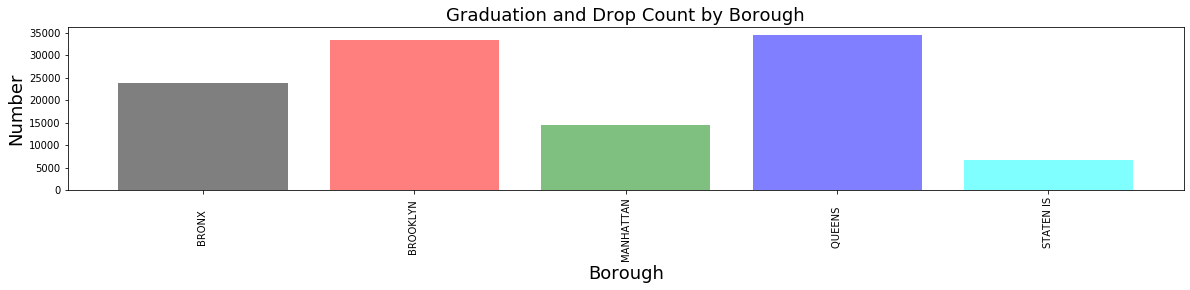

In [32]:
#Ploting Highest Dropout Rate by Borough
Avg_DR_School_byborough_df = School_df.groupby(['Borough']).agg({'Dropout #':'sum'},
                                                                                 'Latitude','Longitude')
Avg_DR_School_byborough_df = Avg_DR_School_byborough_df.reset_index(drop=False)
Avg_DR_School_byborough_df.head()

# Set x axis and tick locations
x_axis = np.arange(len(Avg_DR_School_byborough_df))
tick_locations = [value for value in x_axis]
# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, Avg_DR_School_byborough_df["Dropout #"], color=['black', 'red', 'green', 'blue', 'cyan'], 
        alpha=0.5, align="center")
plt.xticks(tick_locations, Avg_DR_School_byborough_df["Borough"], rotation="vertical")

plt.title("Graduation and Drop Count by Borough",fontsize=18)
plt.ylabel("Number",fontsize=18)
plt.xlabel("Borough",fontsize=18)

# Save an image of the chart and print to screen.Count Plot
#plt.savefig("Images/Graduation and Drop Count by Borough.png")
plt.show()


In [33]:
#Extracting Latitude and Longitude for each High School for Heat Maps and drop NAN valus 
locations = Avg_DR_School_df[["Latitude", "Longitude"]]
locations_clean = locations.fillna(0)

In [34]:
#Ploting Heat Maps for % Dropouts by Latitude and Longitude
fig = gmaps.figure()
rating = Avg_DR_School_df["Dropout #"]

#Zoomimg in for New York City 
new_york_coordinates = (40.75, -74.00)
fig = gmaps.figure(center=new_york_coordinates, zoom_level=10)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations_clean,weights=rating,max_intensity=100,point_radius=15.0)  

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [36]:
#To find Latitude and Longitude for each High School to get Total Grads %
Avg_GR_School_df = School_df.groupby(['School Name','Latitude','Longitude']).agg({'Total Grads #':'sum'},
                                                                                 'Latitude','Longitude')
Avg_GR_School_df = Avg_GR_School_df.reset_index(drop=False)

Avg_GR_School_df.head()


,School Name,Latitude,Longitude,Total Grads #
0,47 The American Sign Language and English Seco...,40.73837,-73.9813,308
1,A. Philip Randolph Campus High School,40.81850,-73.9499,3479
2,ACADEMY FOR SOCIAL ACTION,40.81575,-73.9555,255
3,ACORN Community High School,40.67859,-73.9616,1384
4,ARTS & MEDIA PREPARATORY ACADEMY,40.65909,-73.9287,294


In [37]:
#Ploting Heat Maps for Total Grads % by Latitude and Longitude
fig = gmaps.figure()
rating = Avg_GR_School_df["Total Grads #"]
fig = gmaps.figure(center=new_york_coordinates, zoom_level=10)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations_clean,weights=rating,max_intensity=100,point_radius=5.0)  

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig


Figure(layout=FigureLayout(height='420px'))